# Molybdenum doped Vanadium Dioxide Data

We will be comparing the result of standard punch and fill to that of the technique involving watershed segmentation of the Bragg peaks followed by Laplacian and Matern fill. 

The data can be found on nxrs:
`/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_120K.nxs`

From Matt: the most relevant scattering is found half-integer L planes, with only weak size-effect scattering close to the Bragg peaks; a 3D-deltaPDF should show a clear 2D 'X' pattern.

In [1]:
# Set up directories for {Charlotte,Vishwas}'s machine.
#The repo_dir and base_dir is customized for Charlotte's and Vishwas' laptops.
#It needs to be changed appropriately for other machines. repo_dir corresponds to
#the directory where the git repo 'laplaceinterpolation' is saved.
from   pathlib import Path
import socket
home = str(Path.home())
hostname = str(socket.gethostname())

# If not Charlotte's home, Vishwas's home
if home == '/Users/charlottehaley':
    base_dir = home + '/Documents/Data/Xray/md_54_4b/'
    repo_dir = home + '/Documents/Repos/laplaceinterpolation/'
if home == '/Users/vishwasrao':
    base_dir = home +'/Research/BES_Project/Data/'
    repo_dir = home + '/Research/BES_Project/Repo/laplaceinterpolation/'

save_data_dir = base_dir

# filename and filename_background customized to work on Charlotte's and Vishwas's laptops and on nxrs.
# For other machines, may need some edits.
if "nxrs" in hostname and "nxrs0" not in hostname:
    filename = '/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_120K.nxs'
    filename_background = '/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_background.nxs'
    save_data_dir = home
else:
    filename = base_dir + 'movo2_40_120K.nxs'
    filename_background = base_dir + 'movo2_40_background.nxs'

In [2]:
# loads libraries and functions that are usually used
# functions included: flipaxis, getbraggs, getstencil, peel, 
# standard_punch, laplacian_fill & matern_fill (using Laplacians.jl, not Vishwas's code, YET)
import sys
sys.path.insert(1, repo_dir)

import numpy as np
import matplotlib.pyplot as plt
from   scipy.interpolate import Rbf
from   nexusformat.nexus import *

import scipy.signal
from   astropy.convolution import convolve, Kernel, Gaussian1DKernel
import math
import scipy.ndimage

import math, timeit

# This may work differently for you on the server, note that julia v 1.5.4 should be used (v 1.6.0 is incompatible)
from julia import Julia
julia = Julia(compiled_modules=False)
from julia import Main
julia.include(repo_dir+"/MaternKernelApproximation.jl")

def flipaxis(A,i):
    Aprime=np.swapaxes(np.swapaxes(A,0,i)[::-1],0,i)
    return Aprime

In [3]:
# Load data, print tree.
data = nxload(filename)
data.unlock()

movo2_40_background = nxload(filename_background)
movo2_40_background.unlock()

#print(data.tree)

## Generate the symmetric transform data

In [4]:
z3d = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].data.nxvalue 
# - movo2_40_background.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].data.nxdata Extending the data to
# 6.2, 8.2, 8.2 for convenience during the interpolation step.

## Initialize X, Y, Z and dX, dY, and dZ

In [5]:
# The markers should be the Bragg locations
x = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].Ql.nxvalue
x2 = data.entry.symm_transform[-0.2:6.,-0.2:8.2,-0.2:8.2].Qk.nxvalue
x3 = data.entry.symm_transform[-0.2:6.,-0.2:8.2,-0.2:8.2].Qh.nxvalue

dx = x[1] - x[0]
dx2 = x2[1] - x2[0]
dx3 = x3[1] - x3[0]

## Define the symmetrizing operation and the standard punch

In [6]:
Qh_lim=8
Qk_lim=8
Ql_lim=6

kmin=50*(6-Ql_lim)
kmax=50*(6+Ql_lim)
jmin=50*(8-Qk_lim)
jmax=50*(8+Qk_lim)
imin=50*(8-Qh_lim)
imax=50*(8+Qh_lim)

def symmetrize(res):
    # Convolultion happens over a single octant of the dataset
    # This is a bit ad-hoc as the indices are hard-coded.
    vvals=np.zeros((601,801,801))
    vvals[290:601,390:801,390:801] = res
    vvals[300:601,400:801,0:401] = flipaxis(vvals[300:601,400:801,400:801],2)
    vvals[300:601,0:401,0:801] = flipaxis(vvals[300:601,400:801,0:801],1)
    vvals[0:301,0:801,0:801] = flipaxis(vvals[300:601,0:801,0:801],0)
    # background subtraction - what is the minimum spherically symmetric background - not
    # rigorously based on anything
    # vvals=vvals[kmin:kmax,jmin:jmax,imin:imax]-movo2_40_background.entry.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].data.nxdata-2
    # Anything less than zero is set to zero. No intensity should be less than zero
    # vvals[vvals < 0] = 0
    return vvals[0:600,0:800,0:800]

In [7]:
# Matern Interpolation happens here. 
epsilon = 0. #Regularization parameter
m = 2 #Matern parameter
radius = 0.200; # Punch radius
h = 0.02; # approximate grid spacing. For MoVO2, the grid spacing along all directions are the same.
#For other Crystals, this might not be so. In that case, we have separate values of h,k,l.
# including the boundaries to see how things work
xmin = 0
xmax = 7
ymin = 0
ymax = 9
zmin = 0
zmax = 9
xbegin = ybegin = zbegin =-0.2
z3d_copy =np.copy(z3d) #Creating a copy to ensure the original is not overwritten.
z3d_restored = np.copy(z3d) #Creating a copy to ensure the original is not overwritten.
stride = 10; # This is used to send chunks of the volume data for processing.
#Interpolating across entire data can be time consuming. Instead, dividing into small chunks
#results in smaller but a large number of linear systems. Currently, "stride" is chosen adhoc. 
#For MoVO2, I chose 10 to ensure that the length of the cube of the data that is sent is slightly
#larger than the diameter of the punch. In case of Matern, different "stride" values will result 
#in different interpolation results.  Larger stride values might result in "better" interpolation
#but this comes at a cost. For Laplace, however, interpolation results are independent of the value
#of stride as long as length of the cube of the data that is sent is slightly larger than the
#diameter of the punch. In summary, value of "stride" depends somewhat on the problem. 

starttime = timeit.default_timer()
for i in range(zmin, zmax):
    i1 = int((i-zbegin) /h)-stride #(i2-i1)*h will be the length of the cube
    i2 = i1+2*stride+1 #Here we are sending only the cube surrounding the punch
    #for interpolation.
    #print(i1,i2)
    for j in range(ymin, ymax):
        j1 = int((j-ybegin)/h)-stride;
        j2 = j1+2*stride+1 #(j2-j1)*h will be the length of the cube. For some crystals
        # (j2-j1)*h != (i2-i1)*h because of different aspect ratios.
        #print(j1,j2)
        for k in range(xmin, xmax):
            k1 = int((k-ybegin)/h) - stride
            k2 = k1+2*stride+1 #(k2-k1)*h will be the length of the cube. 
            z3temp = z3d_copy[k1:k2,j1:j2,i1:i2] #Instead of sending the entire z3d, We are just sending a 
    #small section of it for interpolation.
            restored_img, punched_image = julia.Matern3D_Grid(x[k1:k2], x2[j1:j2], x3[i1:i2], z3temp,
                                                              epsilon, radius, h, h, h, m) #h=k=l here
#             print(np.shape(restored_img))
            
            restored_img_reshape = np.reshape(restored_img, (2*stride+1,2*stride+1,2*stride+1))
            z3d_restored[k1:k2, j1:j2, i1:i2] = restored_img_reshape.T #Image needs to be transposed because
            #of a different ordering in Julia
print("Time taken for Matern interpolation with m = 2 and epsilon = 0, punch radius 0.02:", timeit.default_timer() - starttime)

# The result of the Matern interpolation is in z3d_restored

Time taken for Matern interpolation with m = 2 and epsilon = 0, punch radius 0.02: 201.181490671


In [8]:
# Laplace interpolation happens here.
# Interpolated data is in z3d_restored_laplace. Original in z3d.

z3d_copy =np.copy(z3d)
z3d_restored_laplace = np.copy(z3d)
starttime = timeit.default_timer()
for i in range(zmin, zmax):
    i1 = int((i-zbegin) /h)-stride #Please see the comments in the Matern interpolation cell.
    i2 = i1+2*stride+1
    for j in range(ymin, ymax):
        j1 = int((j-ybegin)/h)-stride;
        j2 = j1+2*stride+1
        for k in range(xmin, xmax):
            k1 = int((k-ybegin)/h) - stride
            k2 = k1+2*stride+1
            z3temp = z3d_copy[k1:k2,j1:j2,i1:i2] #Instead of sending the entire z3d, We are just passing a 
    #small section of it for interpolation.
            restored_img, punched_image = julia.Laplace3D_Grid(x[k1:k2], x2[j1:j2], x3[i1:i2], z3temp, radius, h,
                                                              h, h)
            restored_img_reshape = np.reshape(restored_img, (2*stride+1,2*stride+1,2*stride+1))
            z3d_restored_laplace[k1:k2, j1:j2, i1:i2] = restored_img_reshape.T
print("Time taken for Laplace interpolation with punch radius 0.02:", timeit.default_timer() - starttime)

Time taken for Laplace interpolation with punch radius 0.02: 50.07270755899998


(1e-05, 2338.091552734375)

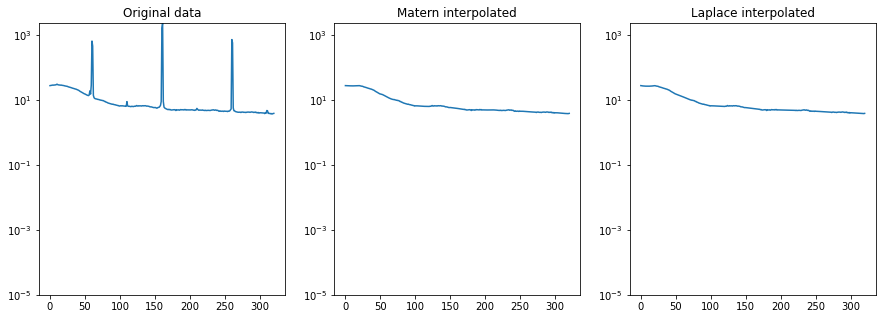

In [9]:
# Taking a 1D slice

# Index in x and y
idx = 60;
idy = 10;

# Find the maximum of the data on the slice common to both z3d_copy and z3d (are these different?) and add 10 for good measure
max1 = np.max(z3d_copy[:,idy,idx])
max2 = np.max(z3d[:,idy,idx])
max_y = np.max([max1, max2])+10

# Plot original data, matern and laplace interpolations
fig,ax=plt.subplots(1,3, figsize=(15,5))
ax[0].semilogy((z3d[:,idy, idx]))
ax[0].set_ylim([0.00001, max_y])
ax[0].set_title("Original data")
ax[1].semilogy((z3d_restored[:, idy,idx]))
ax[1].set_title("Matern interpolated")
ax[1].set_ylim([0.00001, max_y])
ax[2].semilogy((z3d_restored_laplace[:, idy,idx]))
ax[2].set_title("Laplace interpolated")
ax[2].set_ylim([0.00001, max_y])

## Save the Matern and Laplace Interpolated data to an .nxs file 

In [10]:
expt_data = nxload(save_data_dir + 'movo2_40_120K.nxs')['entry'] # or root['entry/masked_transform']

In [11]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_restored[0:311,0:411,0:411]), name='sphere_punch_matern_interp_data')
root.entry.sphere_matern_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_sphere_matern_data.nxs')

In [12]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_restored_laplace[0:311,0:411,0:411]), name='sphere_punch_laplace_interp_data')
root.entry.sphere_laplace_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_sphere_laplace_data.nxs')

In [13]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_copy[0:311,0:411,0:411]), name='original_data')
root.entry.sphere_laplace_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_original_data.nxs')